In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyrsm as rsm
import statsmodels.formula.api as smf
from sklearn import preprocessing
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.families.links import logit
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

import seaborn as sns
# increase plot resolution
# mpl.rcParams["figure.dpi"] = 150



In [2]:
rsm.__version__

'0.7.2'

In [1]:
# ## loading the data - this dataset must NOT be changed
# # cg_organic = pd.read_pickle("data/cg_organic.pkl")

# cg_organic_control = pd.read_pickle("data/cg_organic_control.pkl")
# cg_organic = pd.read_pickle("data/cg_organic.pkl")
# cg_ad_treatment = pd.read_pickle("data/cg_ad_treatment.pkl")

# rsm.describe(cg_organic)

In [4]:
print(cg_organic.shape)
print(cg_organic_control.shape)
print(cg_ad_treatment.shape)

(30000, 21)
(30000, 20)
(150000, 21)


In [5]:
cg_organic.columns

Index(['converted', 'GameLevel', 'NumGameDays', 'NumGameDays4Plus',
       'NumInGameMessagesSent', 'NumSpaceHeroBadges',
       'NumFriendRequestIgnored', 'NumFriends', 'AcquiredSpaceship',
       'AcquiredIonWeapon', 'TimesLostSpaceship', 'TimesKilled',
       'TimesCaptain', 'TimesNavigator', 'PurchasedCoinPackSmall',
       'PurchasedCoinPackLarge', 'NumAdsClicked', 'DaysUser', 'UserConsole',
       'UserHasOldOS', 'training'],
      dtype='object')

In [6]:
cg_ad_treatment.rnd_30k.value_counts()

0    120000
1     30000
Name: rnd_30k, dtype: int64

In [7]:
cg_ad_treatment['GameLevel'] = cg_ad_treatment['GameLevel'].astype('category')
cg_organic['GameLevel'] = cg_organic['GameLevel'].astype('category')
cg_organic_control['GameLevel'] = cg_organic_control['GameLevel'].astype('category')

## Part I: Exploratory Analytics 

In [8]:
prob = cg_organic.converted.value_counts(normalize=True)["yes"] * 100
print(f"The probability of organically converting to Zalon is {np.round(prob,2)}%.")

The probability of organically converting to Zalon is 5.75%.


In [9]:
pd.set_option('display.max_columns', None)

In [10]:
# Get the number of missing and unique values for each feature
missing = cg_organic.isna().sum()
unique = cg_organic.nunique()
# Combine the missing and unique values into a single DataFrame
summary = pd.concat([missing, unique], axis=1)
summary.columns = ["Missing", "Unique"]
# generate remaining summary stats using describe function
cg_summary = cg_organic.describe(include="all").transpose().drop(columns = ['unique', 'top', 'freq'])
cg_summary = pd.concat([cg_summary, summary], axis = 1)
cg_summary

,count,mean,std,min,25%,50%,75%,max,Missing,Unique
converted,30000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2
GameLevel,30000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,10
NumGameDays,30000.0,12.2414,7.097305,1.0,6.0,13.0,18.0,28.0,0,28
NumGameDays4Plus,30000.0,1.257267,3.19121,0.0,0.0,0.0,0.0,24.0,0,25
NumInGameMessagesSent,30000.0,73.7774,107.441593,0.0,0.0,26.0,112.0,1227.0,0,641
NumSpaceHeroBadges,30000.0,0.443933,1.517762,0.0,0.0,0.0,0.0,12.0,0,13
NumFriendRequestIgnored,30000.0,29.5891,33.990783,0.0,0.0,16.0,53.0,121.0,0,122
NumFriends,30000.0,47.733833,94.329939,0.0,0.0,5.0,43.0,486.0,0,485
AcquiredSpaceship,30000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2
AcquiredIonWeapon,30000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2


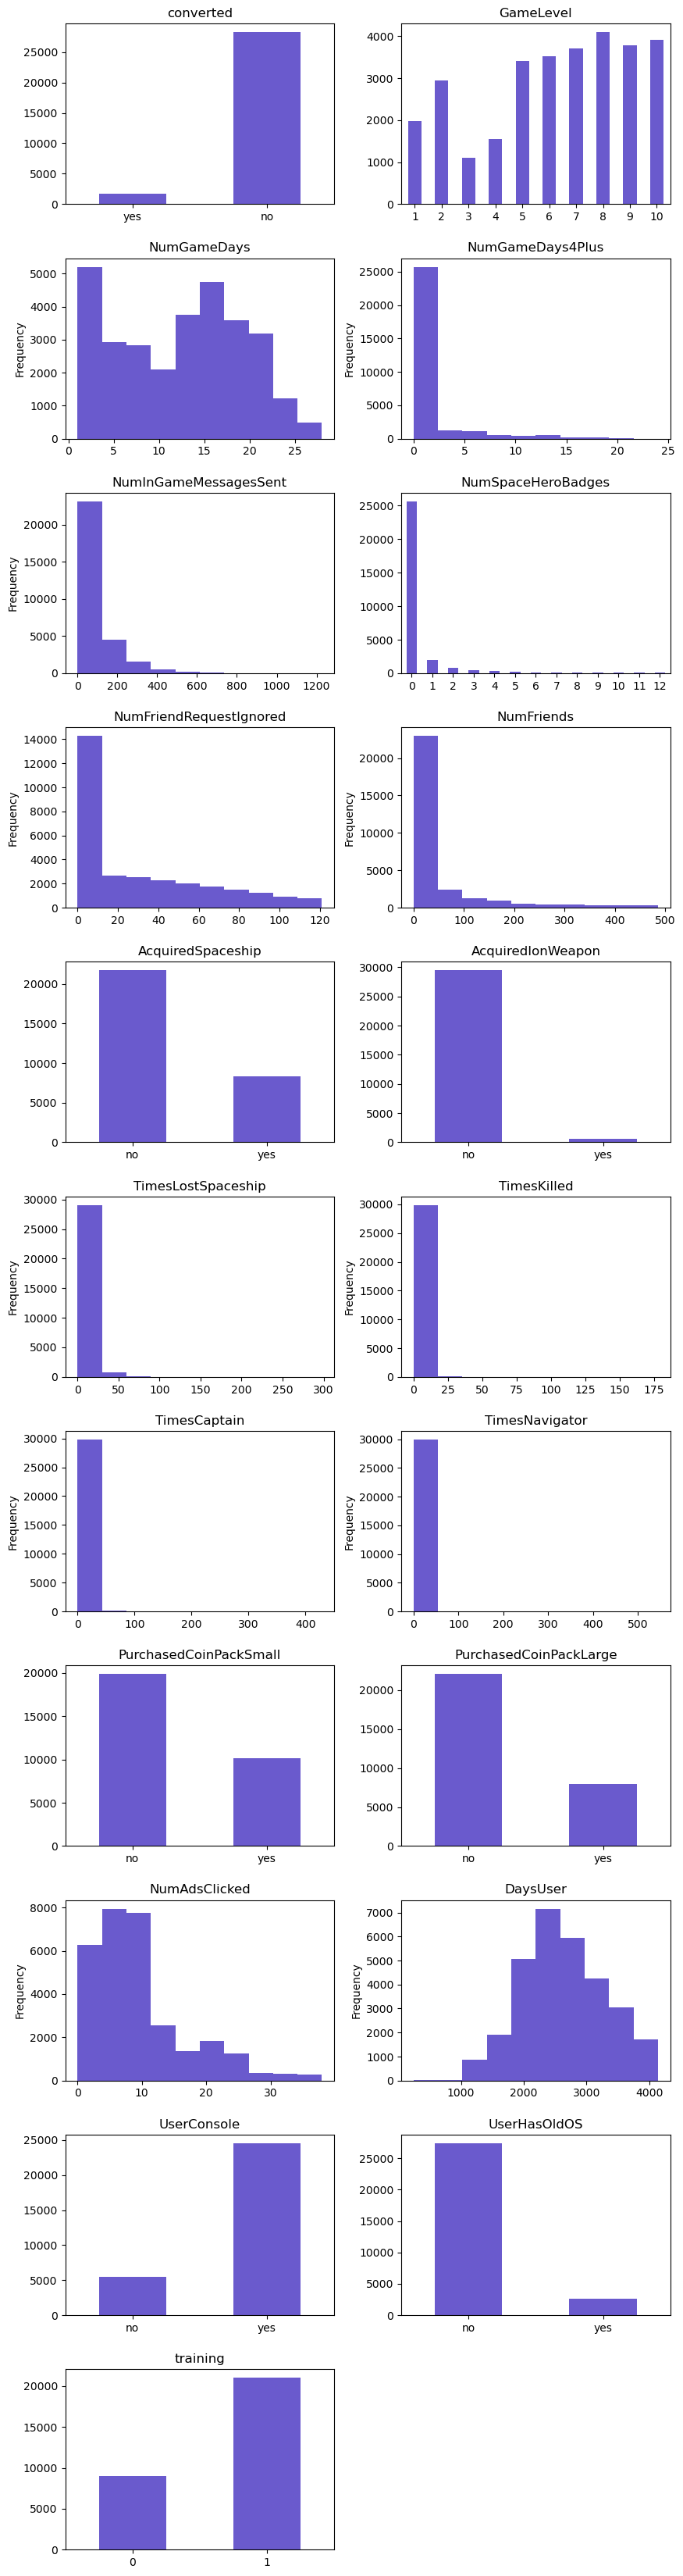

In [11]:
rsm.distr_plot(cg_organic)

## Part II: Predictive Model 

In [12]:
cg_organic.training.value_counts(dropna = False,normalize = True)

1    0.7
0    0.3
Name: training, dtype: float64

In [13]:
# create a variable called 'converted_yes' that has value 1 when converted == 'yes', has value 0 when converted == 'no' and has value np.nan when converted.isna() is True
cg_organic["converted_yes"] = np.where(cg_organic['converted'] == 'yes', 1 ,np.where(cg_organic['converted']  == 'no', 0, np.where(cg_organic['converted'].isna(), np.nan, np.nan)))

In [14]:
cg_organic.converted_yes.value_counts()

0.0    28274
1.0     1726
Name: converted_yes, dtype: int64

In [15]:
lr = smf.glm(
    formula="converted_yes ~ GameLevel + NumGameDays + NumGameDays4Plus + \
       NumInGameMessagesSent + NumSpaceHeroBadges + \
       NumFriendRequestIgnored + NumFriends + AcquiredSpaceship + \
       AcquiredIonWeapon + TimesLostSpaceship + TimesKilled + \
       TimesCaptain + TimesNavigator + PurchasedCoinPackSmall + \
       PurchasedCoinPackLarge + NumAdsClicked + DaysUser + UserConsole + UserHasOldOS",
    family=Binomial(link=logit()),
    data=cg_organic.query("training == 1"),
).fit()

In [16]:
print(lr.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:          converted_yes   No. Observations:                21000
Model:                            GLM   Df Residuals:                    20972
Model Family:                Binomial   Df Model:                           27
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3703.4
Date:                Thu, 16 Feb 2023   Deviance:                       7406.8
Time:                        10:44:30   Pearson chi2:                 1.82e+04
No. Iterations:                     7   Pseudo R-squ. (CS):            0.07837
Covariance Type:            nonrobust                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

In [17]:
print(rsm.model_fit(lr))


Pseudo R-squared (McFadden): 0.188
Pseudo R-squared (McFadden adjusted): 0.182
Area under the RO Curve (AUC): 0.825
Log-likelihood: -3703.377, AIC: 7462.753, BIC: 7685.417
Chi-squared: 18233.421 df(27), p.value < 0.001 
Nr obs: 21,000

None


In [18]:
print(rsm.or_ci(lr))

                            index     OR     OR%   2.5%  97.5% p.values     
1                  GameLevel[T.2]  0.847  -15.3%  0.567  1.265    0.418     
2                  GameLevel[T.3]  1.093    9.3%  0.678  1.762    0.715     
3                  GameLevel[T.4]  0.950   -5.0%  0.603  1.497    0.826     
4                  GameLevel[T.5]  1.085    8.5%  0.748  1.574    0.668     
5                  GameLevel[T.6]  0.969   -3.1%  0.666  1.409    0.867     
6                  GameLevel[T.7]  1.188   18.8%  0.826  1.707    0.353     
7                  GameLevel[T.8]  1.101   10.1%  0.767  1.582    0.602     
8                  GameLevel[T.9]  1.733   73.3%  1.218  2.466    0.002   **
9                 GameLevel[T.10]  2.236  123.6%  1.574  3.176   < .001  ***
10       AcquiredSpaceship[T.yes]  1.730   73.0%  1.502  1.993   < .001  ***
11       AcquiredIonWeapon[T.yes]  1.627   62.7%  1.094  2.420    0.016    *
12  PurchasedCoinPackSmall[T.yes]  0.919   -8.1%  0.801  1.055    0.232     

In [19]:
rsm.vif(lr)

,variable,vif,Rsq
0,GameLevel[T.10],2.925,0.658
1,GameLevel[T.8],2.794,0.642
2,GameLevel[T.9],2.724,0.633
3,GameLevel[T.7],2.613,0.617
4,GameLevel[T.6],2.504,0.601
5,GameLevel[T.5],2.447,0.591
6,GameLevel[T.2],2.263,0.558
7,GameLevel[T.4],1.686,0.407
8,NumFriendRequestIgnored,1.619,0.382
9,NumInGameMessagesSent,1.596,0.373


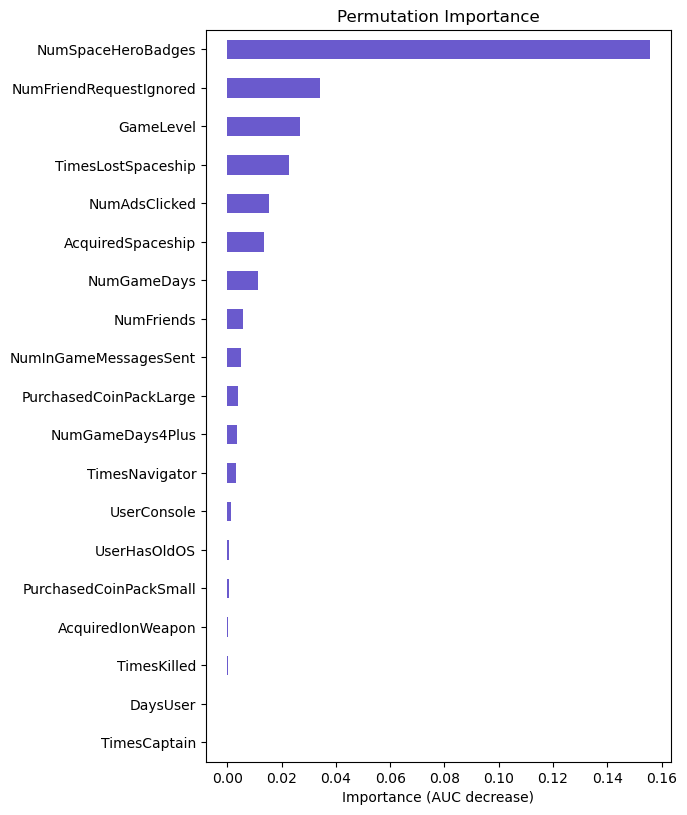

In [20]:
rsm.vimp_plot_sm(lr, cg_organic.query("training == 1"))

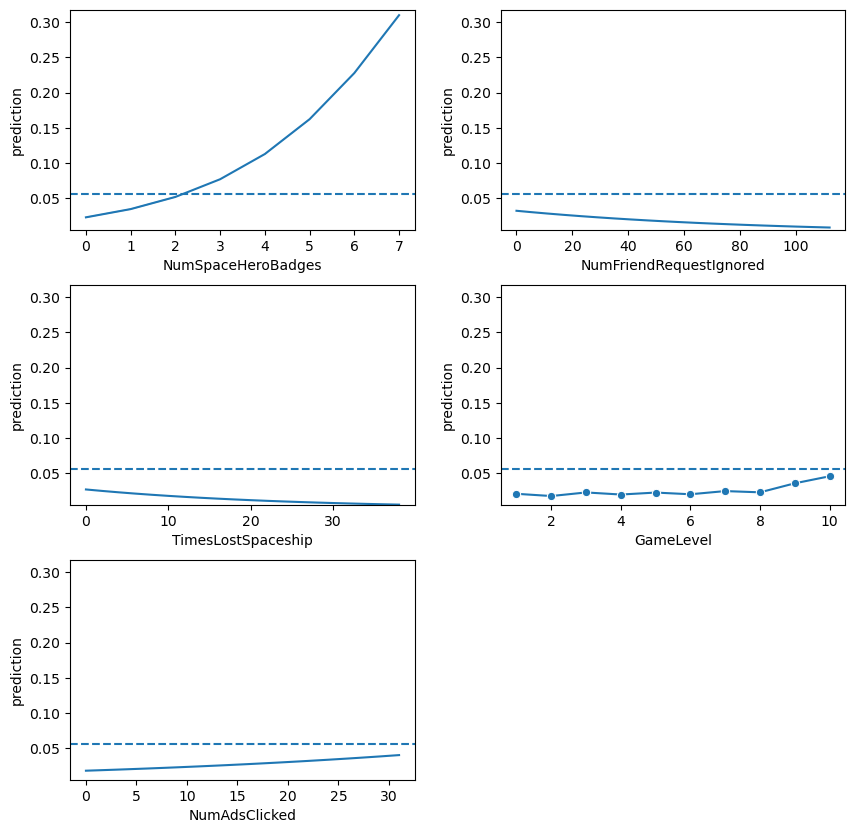

In [21]:
include = ['NumSpaceHeroBadges','NumFriendRequestIgnored','TimesLostSpaceship','GameLevel','NumAdsClicked']
rsm.pred_plot_sm(lr, cg_organic.query("training == 1"),maxq=0.98,incl=include)

In [22]:
cg_organic["pred_logit"] =lr.predict(cg_organic)

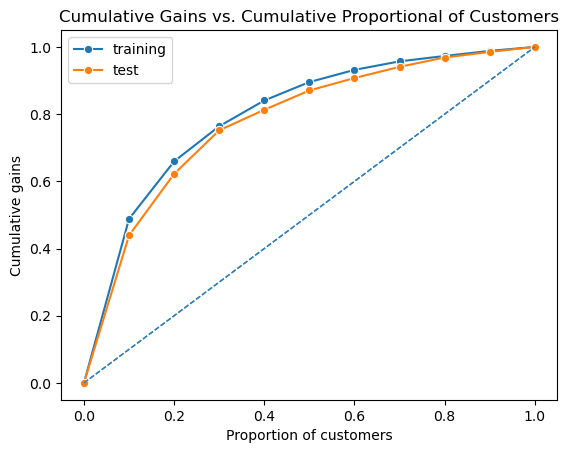

In [38]:
train = rsm.gains_tab(cg_organic[cg_organic.training == 1],rvar='converted_yes',lev=1,pred='pred_logit',qnt=10)
test = rsm.gains_tab(cg_organic[cg_organic.training == 0],rvar='converted_yes',lev=1,pred='pred_logit',qnt=10)

fig_train = rsm.gains_plot(cg_organic[cg_organic.training == 1],rvar='converted_yes',lev=1,pred='pred_logit',qnt=10, label = "training")
fig_test = rsm.gains_plot(cg_organic[cg_organic.training == 0],rvar='converted_yes',lev=1,pred='pred_logit',qnt=10, label = "test")
plt.title('Cumulative Gains vs. Cumulative Proportional of Customers') 
plt.legend()
plt.show()

In [24]:
train_auc = rsm.auc(cg_organic[cg_organic.training == 1].converted_yes, cg_organic[cg_organic.training == 1].pred_logit, 1)
test_auc = rsm.auc(cg_organic[cg_organic.training == 0].converted_yes, cg_organic[cg_organic.training == 0].pred_logit, 1)
print('train AUC:', train_auc)
print('test AUC:', test_auc)

train AUC: 0.8252631002896924
test AUC: 0.805095219332808


## Part III: 

In [25]:

cg_ad_treatment["converted_yes"] = np.where(cg_ad_treatment['converted'] == 'yes', 1 ,np.where(cg_ad_treatment['converted']  == 'no', 0, np.where(cg_ad_treatment['converted'].isna(), np.nan, np.nan)))

In [26]:
def get_prof_rate(df,column,res,cost,revenues):
    percentage = np.mean(df[column]==res)  * 100
    response_rate = np.round(percentage, 2)
    num_response = sum(df[column]==res)
    cost = df.shape[0] * cost
    profit = num_response * revenues - cost
    print ('cost:',cost)
    print('response_rate:',response_rate)
    print('profit:',profit)
    return profit, response_rate

In [27]:
cost = 0
revenues = 14.99
gp1_rrate_profit = get_prof_rate(cg_organic_control,'converted','yes',cost,revenues)

cost: 0
response_rate: 5.69
profit: 25572.94


In [28]:
cost = 1.5
revenues = 14.99
gp2_rrate_profit = get_prof_rate(cg_ad_treatment[cg_ad_treatment['rnd_30k'] == 1],
                                 'converted','yes',cost,revenues)

cost: 45000.0
response_rate: 13.04
profit: 13655.870000000003


In [29]:
# part a.
cg_ad_treatment["pred_logit"] =lr.predict(cg_ad_treatment)
cg_ad_treatment_not_group2 = cg_ad_treatment[cg_ad_treatment['rnd_30k'] != 1]
cg_ad_treatment_not_group2.shape[0]

120000

In [30]:
# part b.
cg_ad_treatment_group3 = cg_ad_treatment_not_group2.sort_values(['pred_logit'],ascending=False)[:30000]
cg_ad_treatment_group3.shape[0]

30000

In [31]:
cost = 1.5
revenues = 14.99
prof_og_model,rasponse_rate_og_model = get_prof_rate(cg_ad_treatment_group3,'converted','yes',cost,revenues)

cost: 45000.0
response_rate: 21.49
profit: 51625.54000000001


In [32]:
# Improvements by model
gp1_prof_improvement_pct = (prof_og_model - gp1_rrate_profit[0])*100/gp1_rrate_profit[0]
gp1_prof_improvement = prof_og_model - gp1_rrate_profit[0]

gp1_resp = rasponse_rate_og_model - gp1_rrate_profit[1]

gp2_prof_improvement_pct = (prof_og_model - gp2_rrate_profit[0])*100/gp2_rrate_profit[0]
gp2_prof_improvement = prof_og_model - gp2_rrate_profit[0]

gp2_resp = rasponse_rate_og_model - gp2_rrate_profit[1]

print(f"""Improvement achieved by model over Group1:
profit improvement: {round(gp1_prof_improvement,2)} dollars ({round(gp1_prof_improvement_pct, 2)}%)
response rate increase by {round(gp1_resp,2)}%""")

print(f"""\nImprovement achieved by model over Group2:
profit improvement: {round(gp2_prof_improvement,2)} dollars ({round(gp2_prof_improvement_pct, 2)}%)
response rate increase by {round(gp2_resp,2)}%""")

Improvement achieved by model over Group1:
profit improvement: 26052.6 dollars (101.88%)
response rate increase by 15.8%

Improvement achieved by model over Group2:
profit improvement: 37969.67 dollars (278.05%)
response rate increase by 8.45%


In [33]:
profit_rrate_df = pd.DataFrame({"Group": [1,2,3],
                                "Profit": [gp1_rrate_profit[0], gp2_rrate_profit[0], prof_og_model],
                                "Response Rate": [gp1_rrate_profit[1], gp2_rrate_profit[1], rasponse_rate_og_model]
                                })

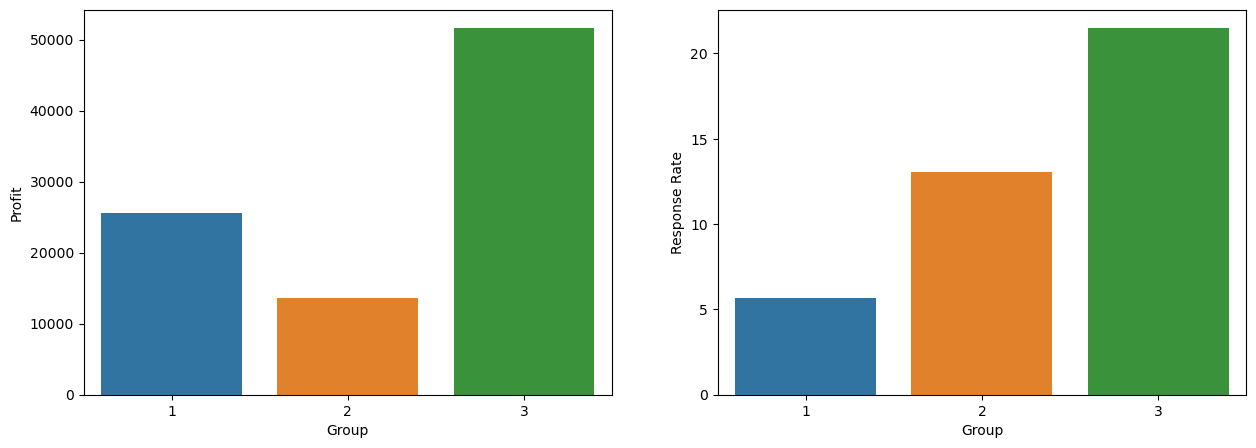

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=False)
sns.barplot(ax = axes[0], y = "Profit", x = "Group", data = profit_rrate_df)
sns.barplot(ax = axes[1], y = "Response Rate", x = "Group", data = profit_rrate_df)
plt.show()

### Gains curve, AUC

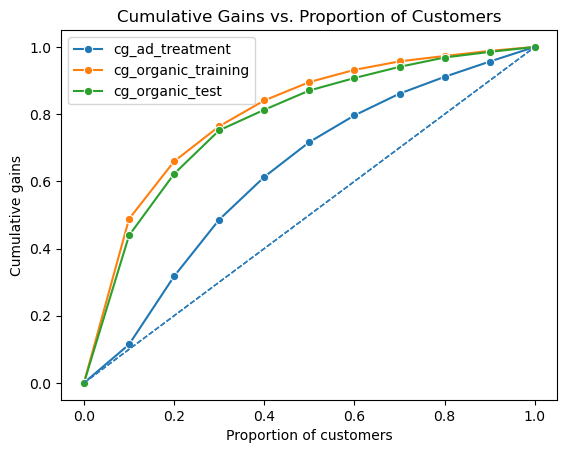

In [40]:
cg_ad_treatment_gains = rsm.gains_tab(cg_ad_treatment_not_group2,rvar='converted_yes',lev=1,pred='pred_logit',qnt=10)
fig_cg_ad_treatment_not_group2 = rsm.gains_plot(cg_ad_treatment_not_group2,rvar='converted_yes',lev=1,pred='pred_logit',qnt=10, label = "cg_ad_treatment")
#fig_train = rsm.gains_plot(cg_organic[cg_organic.training == 1],rvar='converted_yes',lev=1,pred='pred_logit',qnt=10, label = "training")
fig_train = rsm.gains_plot(cg_organic[cg_organic.training == 1],rvar='converted_yes',lev=1,pred='pred_logit',qnt=10, label = "cg_organic_training")
fig_test = rsm.gains_plot(cg_organic[cg_organic.training == 0],rvar='converted_yes',lev=1,pred='pred_logit',qnt=10, label = "cg_organic_test")
plt.title('Cumulative Gains vs. Proportion of Customers') 
plt.legend()
plt.show()

In [50]:
cg_ad_treatment_auc = rsm.auc(cg_ad_treatment_not_group2.converted_yes, cg_ad_treatment_not_group2.pred_logit, 1)
cg_organic_train_auc = rsm.auc(cg_organic[cg_organic.training == 1].converted_yes, cg_organic[cg_organic.training == 1].pred_logit, 1)
cg_organic_test_auc = rsm.auc(cg_organic[cg_organic.training == 0].converted_yes, cg_organic[cg_organic.training == 0].pred_logit, 1)
print('cg_ad_treatment AUC:', cg_ad_treatment_auc)
print('cg_organic_train AUC:', cg_organic_train_auc)
print('cg_organic_test AUC:', cg_organic_test_auc)

cg_ad_treatment AUC: 0.6469901994214315
cg_organic_train AUC: 0.8252631002896924
cg_organic_test AUC: 0.805095219332808


## Part IV: Better Data, Better Predictions 

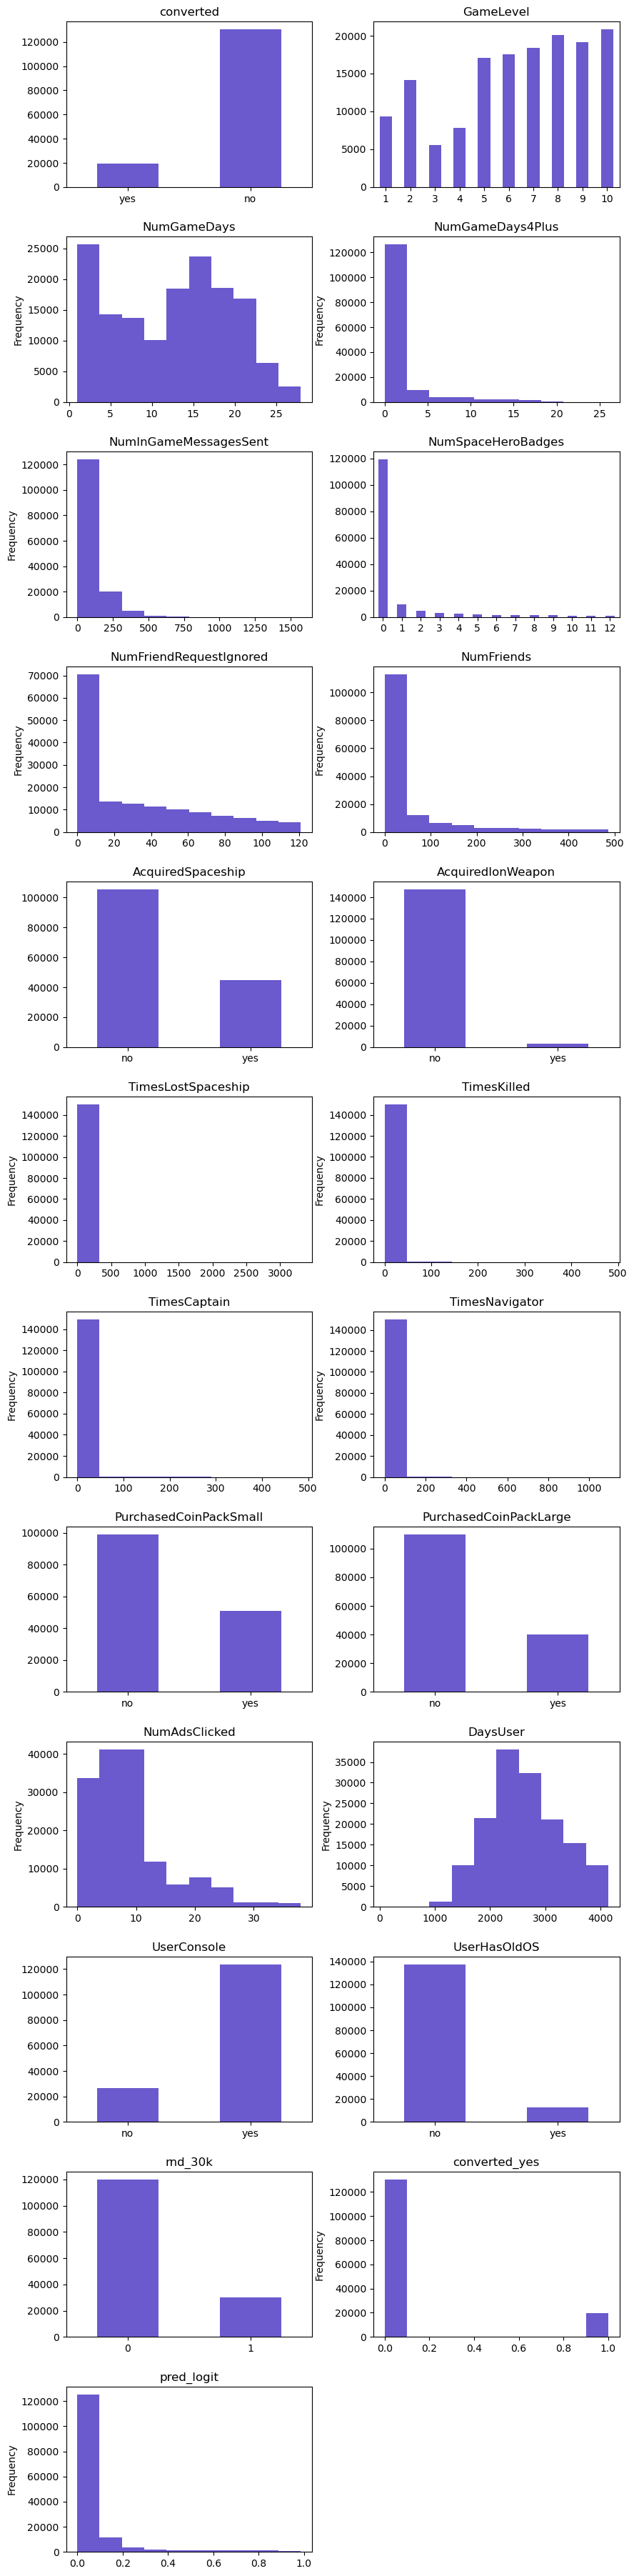

In [42]:
rsm.distr_plot(cg_ad_treatment)

In [52]:
# for lr
cg_ad_treatment["converted_yes"] = np.where(cg_ad_treatment['converted'] == 'yes', 1 ,np.where(cg_ad_treatment['converted']  == 'no', 0, np.where(cg_ad_treatment['converted'].isna(), np.nan, np.nan)))

In [54]:
lr_ad = smf.glm(
    formula="converted_yes ~ GameLevel + NumGameDays + NumGameDays4Plus + \
       NumInGameMessagesSent + NumSpaceHeroBadges + \
       NumFriendRequestIgnored + NumFriends + AcquiredSpaceship + \
       AcquiredIonWeapon + TimesLostSpaceship + TimesKilled + \
       TimesCaptain + TimesNavigator + PurchasedCoinPackSmall + \
       PurchasedCoinPackLarge + NumAdsClicked + DaysUser + UserConsole + UserHasOldOS",
    family=Binomial(link=logit()),
    data=cg_ad_treatment.query("rnd_30k == 1"),
).fit()

In [55]:
print(lr_ad.summary())
print(rsm.model_fit(lr_ad))
print(rsm.or_ci(lr_ad))
print(rsm.vif(lr_ad))
#print(rsm.vimp_plot_sm(lr_ad, cg_ad_treatment.query("rnd_30k == 1")))


                 Generalized Linear Model Regression Results                  
Dep. Variable:          converted_yes   No. Observations:                30000
Model:                            GLM   Df Residuals:                    29972
Model Family:                Binomial   Df Model:                           27
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -10506.
Date:                Thu, 16 Feb 2023   Deviance:                       21013.
Time:                        11:02:02   Pearson chi2:                 3.01e+04
No. Iterations:                     6   Pseudo R-squ. (CS):            0.07132
Covariance Type:            nonrobust                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

In [56]:
cg_ad_treatment["pred_logit_ad"] =lr_ad.predict(cg_ad_treatment)
cg_ad_treatment["pred_logit"] =lr.predict(cg_ad_treatment)

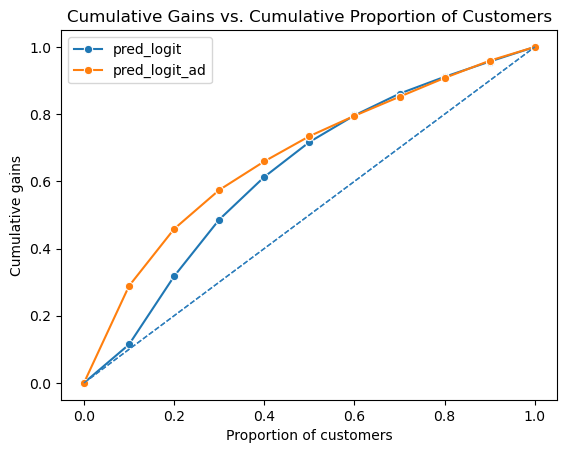

In [57]:
fig_pred_logit = rsm.gains_plot(cg_ad_treatment[cg_ad_treatment['rnd_30k'] != 1],
                                rvar='converted_yes',lev=1,pred='pred_logit',qnt=10, 
                                label = "pred_logit")
fig_pred_logit_ad = rsm.gains_plot(cg_ad_treatment[cg_ad_treatment['rnd_30k'] != 1],
                                    rvar='converted_yes',lev=1,pred='pred_logit_ad',qnt=10, 
                                    label = "pred_logit_ad")
plt.title('Cumulative Gains vs. Cumulative Proportion of Customers') 
plt.legend()
plt.show()

In [58]:
cg_ad_treatment_auc_org = rsm.auc(
    cg_ad_treatment[cg_ad_treatment['rnd_30k'] != 1].converted_yes, 
    cg_ad_treatment[cg_ad_treatment['rnd_30k'] != 1].pred_logit, 1)
cg_ad_treatment_auc_ad_logit = rsm.auc(
    cg_ad_treatment[cg_ad_treatment['rnd_30k'] != 1].converted_yes, 
    cg_ad_treatment[cg_ad_treatment['rnd_30k'] != 1].pred_logit_ad, 1)
print('cg_ad_treatment organic model AUC:', cg_ad_treatment_auc_org)
print('cg_ad_treatment new model  AUC:', cg_ad_treatment_auc_ad_logit)

cg_ad_treatment organic model AUC: 0.6469901994214315
cg_ad_treatment new model  AUC: 0.7035900474870693


In [60]:
cg_ad_treatment_not_group2 = cg_ad_treatment[cg_ad_treatment['rnd_30k'] != 1]
cg_ad_treatment_group3_logit_ad = cg_ad_treatment_not_group2.sort_values(['pred_logit_ad'],ascending=False)[:30000]


In [61]:
cost = 1.5
revenues = 14.99
prof_ad_model,rasponse_rate_ad_model = get_prof_rate(cg_ad_treatment_group3_logit_ad,'converted','yes',cost,revenues)

prof_improvement = prof_ad_model - prof_og_model
print('profit improvement over the organic model:',prof_improvement)

cost: 45000.0
response_rate: 27.4
profit: 78202.81
profit improvement over the organic model: 26577.26999999999


None


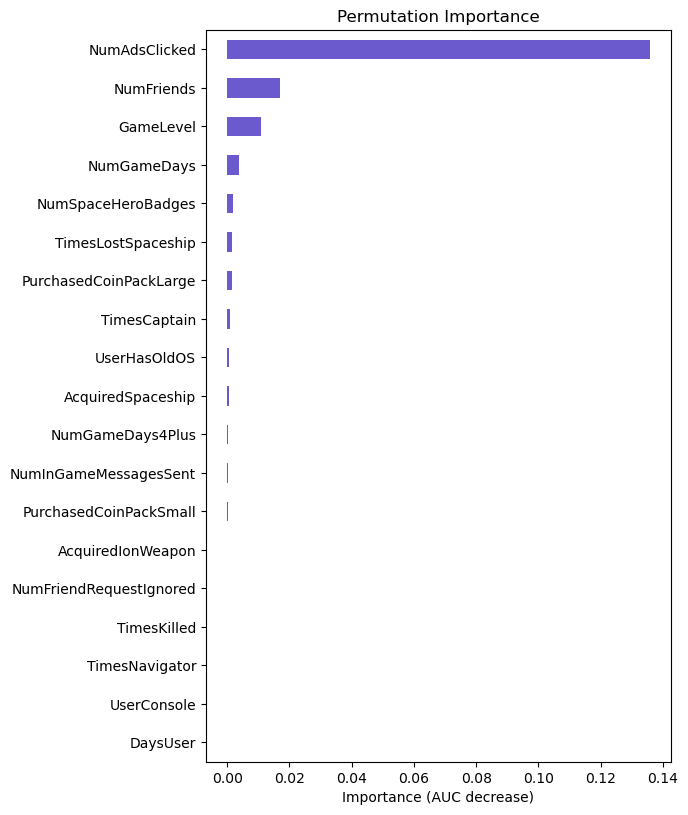

In [62]:
print(rsm.vimp_plot_sm(lr_ad, cg_ad_treatment.query("rnd_30k == 1")))

## Part V: Better Models, Better Predictions 

### neural network 

In [63]:
# for NN
predictors = ['GameLevel', 'NumGameDays', 'NumGameDays4Plus',
       'NumInGameMessagesSent', 'NumSpaceHeroBadges',
       'NumFriendRequestIgnored', 'NumFriends', 'AcquiredSpaceship',
       'AcquiredIonWeapon', 'TimesLostSpaceship', 'TimesKilled',
       'TimesCaptain', 'TimesNavigator', 'PurchasedCoinPackSmall',
       'PurchasedCoinPackLarge', 'NumAdsClicked', 'DaysUser', 'UserConsole',
       'UserHasOldOS']
response = 'converted_yes'

In [64]:
X = cg_ad_treatment[predictors]
y = cg_ad_treatment[response]

In [65]:
X.dtypes

GameLevel                  category
NumGameDays                   int32
NumGameDays4Plus              int32
NumInGameMessagesSent         int32
NumSpaceHeroBadges            int32
NumFriendRequestIgnored       int32
NumFriends                    int32
AcquiredSpaceship          category
AcquiredIonWeapon          category
TimesLostSpaceship            int32
TimesKilled                   int32
TimesCaptain                  int32
TimesNavigator                int32
PurchasedCoinPackSmall     category
PurchasedCoinPackLarge     category
NumAdsClicked                 int32
DaysUser                      int32
UserConsole                category
UserHasOldOS               category
dtype: object

In [66]:
# Create dummy variables for the categorical column
dummies = pd.get_dummies(X, columns=['AcquiredSpaceship','AcquiredIonWeapon','PurchasedCoinPackSmall','PurchasedCoinPackLarge','UserConsole','UserHasOldOS'])
# Add the dummy variables to the original DataFrame
X = pd.concat([X, dummies], axis=1)
X.drop(['AcquiredSpaceship','AcquiredIonWeapon','PurchasedCoinPackSmall','PurchasedCoinPackLarge','UserConsole','UserHasOldOS'], axis=1, inplace=True)


In [79]:
# Define the parameter grid to search
param_grid = {'hidden_layer_sizes': [(2,), (3,)],
              'activation': ['tanh', 'relu'],
              'solver': ['sgd', 'adam'],
              'alpha': [0.0001, 0.05],
              'max_iter': [100,500]}

param_grid = {'hidden_layer_sizes': [(3,)],
              'activation': ['relu'],
              'solver': ['adam'],
              'alpha': [0.05],
              'max_iter': [500]}

In [80]:
# Create the classifier

mlp = MLPClassifier()

# Create the grid search
grid_search = GridSearchCV(mlp, param_grid, cv=5)

# Fit the grid search to the data
#grid_search.fit(X[cg_ad_treatment.rnd_30k == 1], y[cg_ad_treatment.rnd_30k == 1])
grid_search.fit(X, y)

# Get the best parameters
best_parameters = grid_search.best_params_

# Train a new classifier using the best parameters
clf = MLPClassifier(hidden_layer_sizes=best_parameters['hidden_layer_sizes'],
                    activation=best_parameters['activation'],
                    solver=best_parameters['solver'],
                    alpha=best_parameters['alpha'],
                    max_iter=best_parameters['max_iter'])
clf.fit(X[cg_ad_treatment.rnd_30k == 1], y[cg_ad_treatment.rnd_30k == 1])

MLPClassifier(alpha=0.05, hidden_layer_sizes=(3,), max_iter=500)

{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (3,), 'max_iter': 500, 'solver': 'adam'}


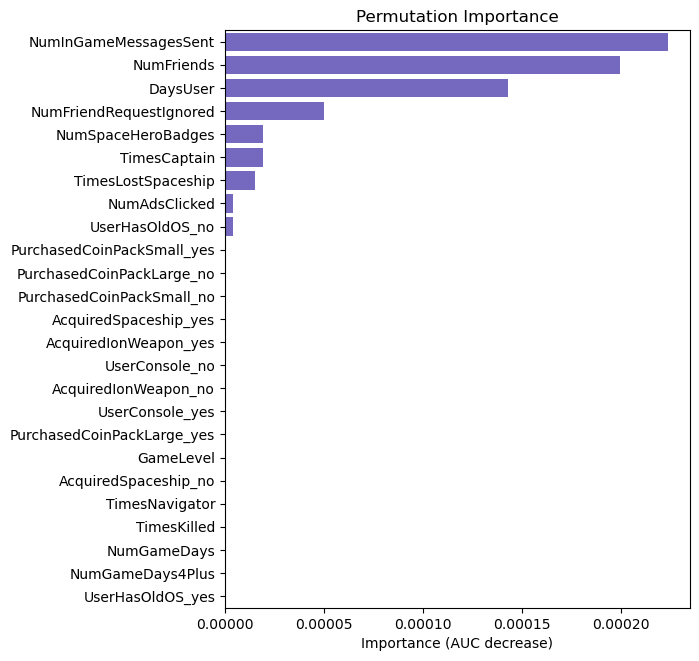

In [81]:
print(best_parameters)
rsm.vimp_plot_sk(clf,X[cg_ad_treatment.rnd_30k == 1],y[cg_ad_treatment.rnd_30k == 1])

In [82]:
cg_ad_treatment["pred_nn"] =clf.predict_proba(X)[:,1]

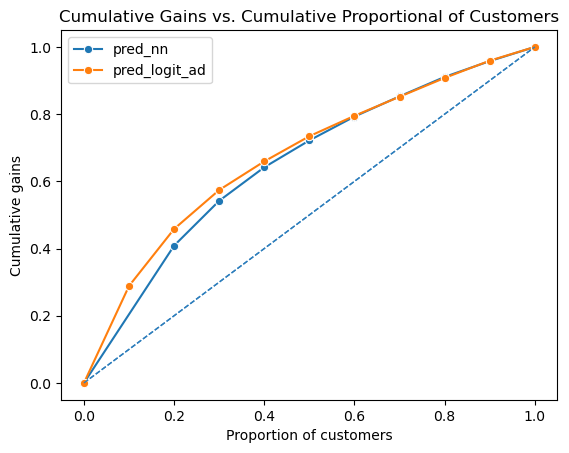

In [83]:
fig_pred_nn = rsm.gains_plot(cg_ad_treatment[cg_ad_treatment['rnd_30k'] != 1],
                            rvar='converted_yes',lev=1,pred='pred_nn',qnt=10, label = "pred_nn")
fig_pred_logit_ad = rsm.gains_plot(cg_ad_treatment[cg_ad_treatment['rnd_30k'] != 1],
                                rvar='converted_yes',lev=1,pred='pred_logit_ad',qnt=10, 
                                label = "pred_logit_ad")
plt.title('Cumulative Gains vs. Cumulative Proportional of Customers') 
plt.legend()
plt.show()

In [72]:
cg_ad_treatment_auc_logit = rsm.auc(
    cg_ad_treatment[cg_ad_treatment['rnd_30k'] != 1].converted_yes, 
    cg_ad_treatment[cg_ad_treatment['rnd_30k'] != 1].pred_logit_ad, 1)
cg_ad_treatment_auc_nn = rsm.auc(
    cg_ad_treatment[cg_ad_treatment['rnd_30k'] != 1].converted_yes, 
    cg_ad_treatment[cg_ad_treatment['rnd_30k'] != 1].pred_nn, 1)
print('cg_ad_treatment_auc_logit:', cg_ad_treatment_auc_logit)
print('cg_ad_treatment_auc_nn:', cg_ad_treatment_auc_nn)

cg_ad_treatment_auc_logit: 0.7035900474870693
cg_ad_treatment_auc_nn: 0.5000047954730734


In [73]:
cg_ad_treatment_not_group2 = cg_ad_treatment[cg_ad_treatment['rnd_30k'] != 1]
cg_ad_treatment_group3_nn = cg_ad_treatment_not_group2.sort_values(['pred_nn'],ascending=False)[:30000]
prof_nn_model,rasponse_rate_nn_model = get_prof_rate(
    cg_ad_treatment_group3_nn,'converted','yes',cost,revenues)

prof_improvement = prof_nn_model - prof_ad_model
print('profit improvement of neural network "ad" model over the logit ad model:',prof_improvement)


cost: 45000.0
response_rate: 13.18
profit: 14285.450000000004
profit improvement of neural network "ad" model over the logit ad model: -63917.35999999999


In [83]:
# Initialize the Random Forest classifier with default parameters
rf = RandomForestClassifier()

# Define a parameter grid containing the hyperparameters to be tuned using grid search
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [5, 10, 15],
    'max_features': ['sqrt', 'log2']
}

# Create an instance of the GridSearchCV() class and pass the random forest model and parameter grid as arguments
grid_search = GridSearchCV(rf, param_grid, cv=5)

# Fit the grid search object to the training data
grid_search.fit(X[cg_ad_treatment.rnd_30k == 1], y[cg_ad_treatment.rnd_30k == 1])

# Get the best parameters
best_parameters = grid_search.best_params_

rf = RandomForestClassifier(n_estimators=best_parameters['n_estimators'],
                    max_depth=best_parameters['max_depth'],
                    max_features=best_parameters['max_features'])


# Train the model on the training data
rf.fit(X[cg_ad_treatment.rnd_30k == 1], y[cg_ad_treatment.rnd_30k == 1])

RandomForestClassifier(max_depth=10, n_estimators=300)

In [84]:
cg_ad_treatment["pred_rf"] =rf.predict_proba(X)[:,1]

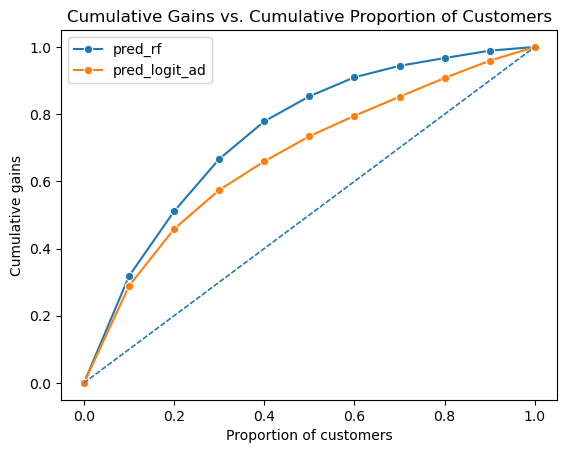

In [85]:
fig_pred_rf = rsm.gains_plot(cg_ad_treatment[cg_ad_treatment['rnd_30k'] != 1],
                            rvar='converted_yes',lev=1,pred='pred_rf',qnt=10, label = "pred_rf")
fig_pred_logit_ad = rsm.gains_plot(cg_ad_treatment[cg_ad_treatment['rnd_30k'] != 1],
                            rvar='converted_yes',lev=1,pred='pred_logit_ad',qnt=10, label = "pred_logit_ad")
plt.title('Cumulative Gains vs. Cumulative Proportion of Customers') 
plt.legend()
plt.show()

In [88]:
cg_ad_treatment_auc_logit = rsm.auc(
    cg_ad_treatment[cg_ad_treatment['rnd_30k'] != 1].converted_yes, 
    cg_ad_treatment[cg_ad_treatment['rnd_30k'] != 1].pred_logit_ad, 1)
cg_ad_treatment_auc_rf = rsm.auc(
    cg_ad_treatment[cg_ad_treatment['rnd_30k'] != 1].converted_yes, 
    cg_ad_treatment[cg_ad_treatment['rnd_30k'] != 1].pred_rf, 1)
print('cg_ad_treatment_auc_logit:', cg_ad_treatment_auc_logit)
print('cg_ad_treatment_auc_rf:', cg_ad_treatment_auc_rf)

cg_ad_treatment_auc_logit: 0.7035900474870693
cg_ad_treatment_auc_rf: 0.7853676493546431


In [92]:
cg_ad_treatment_not_group2 = cg_ad_treatment[cg_ad_treatment['rnd_30k'] != 1]
cg_ad_treatment_group3_nn = cg_ad_treatment_not_group2.sort_values(['pred_rf'],ascending=False)[:30000]
prof_rf_model,rasponse_rate_rf_model = get_prof_rate(
    cg_ad_treatment_group3_nn,'converted','yes',cost,revenues)

prof_improvement = prof_rf_model - prof_ad_model
print('profit improvement of random forest "ad" model over the logit ad model:',round(prof_improvement,2))


cost: 45000.0
response_rate: 31.1
profit: 94856.70000000001
profit improvement of random forest "ad" model over the logit ad model: 16653.89
